## Gate Cutting to Reduce Circuit Width

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList
from qiskit.primitives import Estimator

from circuit_knitting_toolbox.utils.simulation import ExactSampler as Sampler
from circuit_knitting_toolbox.circuit_cutting import (
    partition_problem,
    execute_experiments,
    reconstruct_expectation_values,
)

#### Create a circuit to cut

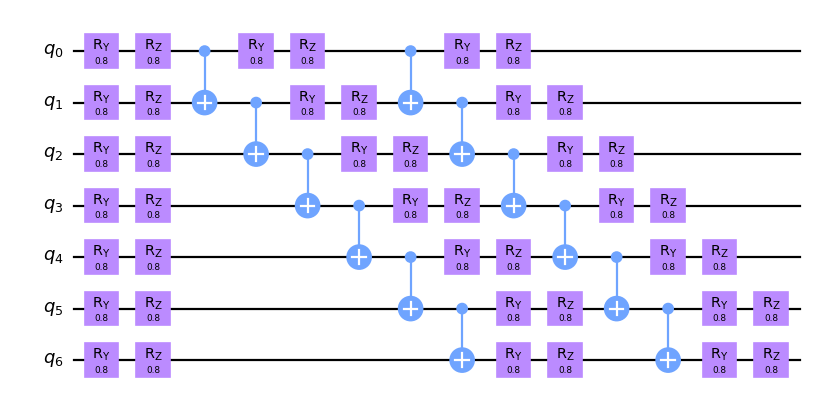

In [2]:
circuit = EfficientSU2(7, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)

circuit.draw("mpl", scale=0.8)

#### Specify some observables for which we wish to simulate expectation values

In [3]:
observables = PauliList(
    ["ZZIIIII", "IZZIIII", "IIZZIII", "IIIIXXI", "IIIIXXI", "IIIIIXX"]
)

#### Decompose the circuit and observables according to a specified qubit partitioning using `decompose_problem`

*Arguments*
- **circuit**: The circuit to separate
- **observables**: The observables to separate
- **partition_labels**: A sequence of labels. Each label corresponds to the `circuit`
qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.
    
*Outputs*
- **subcircuits**: The subcircuits resulting from decomposing nonlocal gates and separating the input ``circuit``
- **subobservables**: A dictionary mapping a partition label to a list of
    Pauli observables corresponding only to the specified partitions' qubits

In [4]:
subcircuits, subobservables = partition_problem(
    circuit, "AAABBBB", observables=observables
)

#### Run the cutting experiments using `execute_experiments`

*Arguments*
- **subcircuits**: The subcircuits resulting from decomposing nonlocal gates and separating the circuit
- **subobservables**: A dictionary mapping a partition label to a list of
    Pauli observables corresponding only to the specified partitions' qubits
- **num_samples** (`int`): The number of samples to draw from the joint quasiprobability distribution
- **samplers**: Sampler(s) used to run the sub-experiments. The sub-experiments will be split by qubit partition, and each partition's sub-experiments will be run on the same sampler. If there are more partitions than samplers specified, the partitions will be assigned to the samplers in rotating order.
        
*Outputs*
- **quasi_dists**: A 3D list of length-2 tuples holding the quasi distributions and QPD bit information for each sub-experiment
- **coefficients**: The coefficients corresponding to each unique sample

In [5]:
%%capture

sampler1 = Sampler()
sampler2 = Sampler()

quasi_dists, coefficients = execute_experiments(
    subcircuits,
    subobservables,
    num_samples=1500,
    samplers=[sampler1, sampler2],
)

#### Reconstruct the simulated expectation values using `reconstruct_expectation_values`

*Arguments*
- **quasi_dists**: A 3D sequence of length-2 tuples containing the quasi distributions and QPD bit information from each sub-experiment
- **coefficients**: A sequence of coefficients, such that each coefficient is associated with one unique sample
- **subobservables**: A mapping from qubit partition label to a list of sub-observables associated with those qubits

*Outputs*
- **simulated_expvals**: A list of expectation values constructed with quasiprobability simulation -- one for each input observable

In [6]:
simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    subobservables,
)

#### Compare the simulated expectation values with the exact

In [7]:
exact_expvals = (
    Estimator().run([circuit] * len(observables), list(observables)).result().values
)
print(f"Simulated expectation values: {simulated_expvals}")
print(f"Exact expectation values: {exact_expvals}")
print(f"Absolute errors in estimation: {simulated_expvals-exact_expvals}")

Simulated expectation values: [-0.12378794101560311, 0.023936873139566835, 0.004858468009659031, -0.35203609910253647, -0.35203609910253647, -0.4836484101990028]
Exact expectation values: [-0.11265361  0.0342114   0.00052587 -0.40473634 -0.40473634 -0.47307676]
Absolute errors in estimation: [-0.01113433 -0.01027453  0.0043326   0.05270024  0.05270024 -0.01057165]
